# KNN


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
X_train = pd.read_csv("../../data/X_train.csv", index_col=0)
y_train = pd.read_csv("../../data/y_train.csv", index_col=0)
X_test = pd.read_csv("../../data/X_test.csv", index_col=0)
y_test = pd.read_csv("../../data/y_test.csv", index_col=0)

## Feature selection

Because there are so many features it may be helpful to use PCA or another feature reduction method to do so before creating the model. Create a simple KNN model with the first two principal components and a visualization to see how well it performs. 


In [3]:
# Most important prediction features from Logit model
features = {}
features["Happiness"] = ["Housing satisfaction", "FWBscore", "Stress", "Health", "Race_Hispanic", 
                         "KHscore", "Age", "Education", "Unemployed", "Marital status_2"]

features["Future"] = ["Probability of 75 years", "Goal confidence", "FSscore", "Race_Black - Non-Hispanic", "Age",
                      "Housing satisfaction", "FWBscore", "Stress", "Health", "Race_Hispanic"]

features["Hardwork"] = ["Age", "Housing satisfaction", "Health", "FSscore", "Materialism", "Race_Hispanic", 
                        "Probability of 75 years", "Planning", "FWBscore", "Student"]



## Hyperparameter tuning



In [4]:
def hyperparameter_tuning(X_train, X_test, y_train, y_test, function, param_grid, scoring, cv):
    mod_cv = sklearn.model_selection.GridSearchCV(function, param_grid=param_grid, scoring=scoring, cv=cv)
    
    mod_cv.fit(X_train, y_train)
    best_param = mod_cv.best_params_
    best_train_score = mod_cv.best_score_
    
    y_pred = mod_cv.predict(X_test)
    
    score_dict = {"Best Hyperparameters": best_param,
                  "Best training score": best_train_score,
                  "Accuracy": sklearn.metrics.accuracy_score(y_test, y_pred), 
                  "F1 score": sklearn.metrics.f1_score(y_test, y_pred),
                  "AUC": sklearn.metrics.roc_auc_score(y_test, y_pred)}
            
    return score_dict, y_pred

In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10, 1),
              "p": [1, 2]}

scores_simplified = {}
y_preds_simplified = {}

for i in y_train.columns:
    print(f"{i} prediction", "\n")
    
    X_train_simplified = X_train[features[i]]
    X_test_simplified = X_test[features[i]]
    
    train = y_train[i]
    test = y_test[i]
    
    scores_simplified[i], y_preds_simplified[i] = hyperparameter_tuning(X_train_simplified, X_test_simplified, train, test, knn, param_grid, "accuracy", 5)
    
    print(scores_simplified[i], "\n")

Happiness prediction 

{'Best Hyperparameters': {'n_neighbors': 9, 'p': 2}, 'Best training score': 0.7178166838311019, 'Accuracy': 0.7265238879736409, 'F1 score': 0.7465648854961833, 'AUC': 0.7249978132995125} 

Future prediction 

{'Best Hyperparameters': {'n_neighbors': 9, 'p': 1}, 'Best training score': 0.6838311019567456, 'Accuracy': 0.6968698517298187, 'F1 score': 0.7306002928257687, 'AUC': 0.6912685617775438} 

Hardwork prediction 

{'Best Hyperparameters': {'n_neighbors': 9, 'p': 1}, 'Best training score': 0.6366632337796087, 'Accuracy': 0.6260296540362438, 'F1 score': 0.6868965517241379, 'AUC': 0.6107127022833074} 



In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10, 1),
              "p": [1, 2]}

scores = {}
y_preds = {}

for i in y_train.columns:
    print(f"{i} prediction", "\n")
    
    train = y_train[i]
    test = y_test[i]
    
    scores[i], y_preds[i] = hyperparameter_tuning(X_train, X_test, train, test, knn, param_grid, "accuracy", 5)
    
    print(scores[i], "\n")

Happiness prediction 

{'Best Hyperparameters': {'n_neighbors': 8, 'p': 1}, 'Best training score': 0.7077239958805355, 'Accuracy': 0.6680395387149918, 'F1 score': 0.7012601927353596, 'AUC': 0.6633793269335899} 

Future prediction 

{'Best Hyperparameters': {'n_neighbors': 9, 'p': 1}, 'Best training score': 0.6700308959835221, 'Accuracy': 0.6457990115321252, 'F1 score': 0.7009735744089012, 'AUC': 0.6336557653922923} 

Hardwork prediction 

{'Best Hyperparameters': {'n_neighbors': 9, 'p': 1}, 'Best training score': 0.6203913491246138, 'Accuracy': 0.6202635914332785, 'F1 score': 0.6903962390866353, 'AUC': 0.6001246951895367} 



## Model Evaluation

ROC curve and area under the curve visualization. Recall, Precision, Specificity, and F1 Score. Recognize that this model is being used to predict the above very happy, optimistic about the future, and the importance of hardwork so precision and recall may be important metrics to pay attention to. 

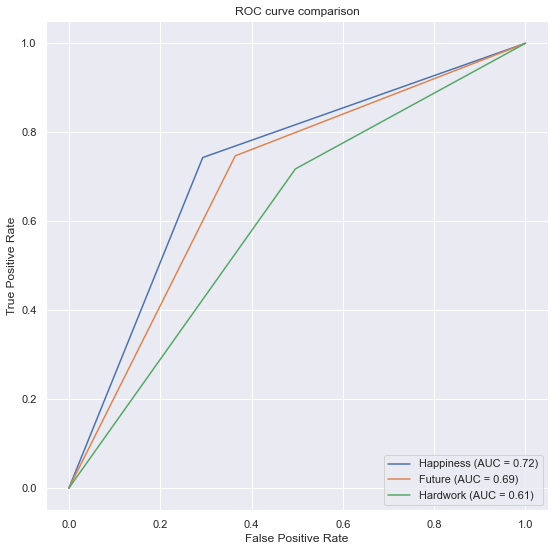

In [7]:
def plot_roc(y_true, y_pred, labels):
    fig, ax = plt.subplots(1, 1, figsize=(9,9))
    for label in labels:
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true[label], y_pred[label])
        auc = sklearn.metrics.auc(fpr, tpr)
        display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=label)
        display.plot(ax=ax)
    
    plt.title("ROC curve comparison")
    plt.savefig("../../results/KNN_ROC.pdf")
    plt.show()

plot_roc(y_test, y_preds_simplified, y_test.columns)

In [8]:
results = pd.read_csv("../../results/model_scores.csv", index_col=0)

if results.isin(["KNN"]).any(axis=None)==False:
    for i in y_train.columns:

        s = pd.DataFrame(scores[i]).reset_index().drop(0, axis=0)
        s["Target"] = i
        s["Model"] = "KNN"
        results = pd.concat([results, s], axis=0)
        results = results.drop(["Best Hyperparameters", "index"], axis=1)
    
results

,Best training score,Accuracy,F1 score,AUC,Target,Model
1,0.755712,0.747941,0.775660,0.742803,Happiness,Logistic Regression
1,0.717608,0.714992,0.752504,0.706899,Future,Logistic Regression
1,0.667356,0.669687,0.731773,0.649861,Hardwork,Logistic Regression
1,0.707724,0.668040,0.701260,0.663379,Happiness,KNN
1,0.670031,0.645799,0.700974,0.633656,Future,KNN
1,0.620391,0.620264,0.690396,0.600125,Hardwork,KNN
1,0.745005,0.734761,0.764964,0.729112,Happiness,Random Forest
1,0.707724,0.694399,0.734811,0.686013,Future,Random Forest
1,0.662204,0.662273,0.729551,0.639761,Hardwork,Random Forest
1,0.746859,0.745470,0.772627,0.740663,Happiness,XGBoost


In [9]:
results.to_csv("../../results/model_scores.csv")

In [20]:
for i in y_train.columns:
    print(f"{i} scores", "\n\n", 
          results[results["Target"]==i].drop("Target", axis=1).sort_values("Accuracy", ascending=False), 
          "\n", sep="")

Happiness scores

   Best training score  Accuracy  F1 score       AUC                Model
1             0.755712  0.747941  0.775660  0.742803  Logistic Regression
1             0.746859  0.745470  0.772627  0.740663              XGBoost
1             0.745005  0.734761  0.764964  0.729112        Random Forest
1             0.707724  0.668040  0.701260  0.663379                  KNN

Future scores

   Best training score  Accuracy  F1 score       AUC                Model
1             0.717608  0.714992  0.752504  0.706899  Logistic Regression
1             0.713079  0.705107  0.744650  0.696579              XGBoost
1             0.707724  0.694399  0.734811  0.686013        Random Forest
1             0.670031  0.645799  0.700974  0.633656                  KNN

Hardwork scores

   Best training score  Accuracy  F1 score       AUC                Model
1             0.667356  0.669687  0.731773  0.649861  Logistic Regression
1             0.667147  0.663921  0.729443  0.642407        